In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy

In [36]:
def load_cfar10_batch(path):
    """ Based on: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
    """
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(batch['labels'])
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [37]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

In [38]:
# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


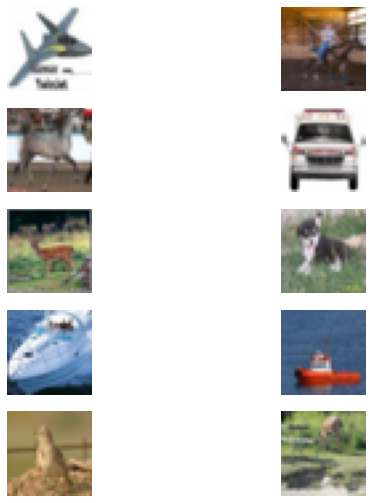

In [39]:
# show some random pics

show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)
x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(show_n // 2, 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    col_idx = 1 - int(idx % 2 == 0)
    ax = axs[idx // 2, col_idx]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [40]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [41]:
print(np.mean(x_train, axis=0))
print(np.mean(x_train, axis=0).shape)
print(np.std(x_train, axis=0))
print(x_train.shape)

print(np.mean(x_val, axis=0))
print(np.std(x_val, axis=0))

print(np.mean(x_test, axis=0))
print(np.std(x_test, axis=0))

print(y_train.shape)
print(y_train.shape[0])

[ 1.14188659e-15 -6.18216589e-16  8.90314489e-15 ...  5.31555910e-15
  8.26625435e-15  1.97581895e-14]
(3072,)
[1. 1. 1. ... 1. 1. 1.]
(10000, 3072)
[-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
[0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
[-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
[0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]
(10000,)
10000


In [42]:
x_train.shape

(10000, 3072)

In [117]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_train.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_train])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_val.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_val])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

iteration 0: train loss 2.471734, acc 0.082700
iteration 0: val loss 2.459326, acc 0.086300
iteration 10: train loss 1.738323, acc 0.406100
iteration 10: val loss 1.830131, acc 0.366500
iteration 20: train loss 1.678044, acc 0.426900
iteration 20: val loss 1.805709, acc 0.378400
iteration 30: train loss 1.642529, acc 0.444400
iteration 30: val loss 1.797263, acc 0.383100


In [44]:
def eval_numerical_gradient(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [84]:
def eval_numerical_gradient_double(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxph = f(x) # evalute f(x + h)
        
        x[ix] = old_value - h # decrease by h
        fxmh = f(x) # evalute f(x - h)
        x[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        grad[ix] = (fxph - fxmh) / (2*h) # the slope
        it.iternext() # step to next dimension

    return grad

In [85]:
def loss(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return loss

def grad(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return dW

In [86]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
    return loss(x_train[:2], y_train[:2], W)

W = np.random.rand(3072, 10) * 0.001 # random weight vector
df = eval_numerical_gradient_double(CIFAR10_loss_fun, W) # get the gradient

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(11, 4)
(11, 5)
(11, 6)
(11, 7)
(11, 8)
(11, 9)
(12, 0)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(12, 9)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 5)
(13, 6)
(13,

(106, 7)
(106, 8)
(106, 9)
(107, 0)
(107, 1)
(107, 2)
(107, 3)
(107, 4)
(107, 5)
(107, 6)
(107, 7)
(107, 8)
(107, 9)
(108, 0)
(108, 1)
(108, 2)
(108, 3)
(108, 4)
(108, 5)
(108, 6)
(108, 7)
(108, 8)
(108, 9)
(109, 0)
(109, 1)
(109, 2)
(109, 3)
(109, 4)
(109, 5)
(109, 6)
(109, 7)
(109, 8)
(109, 9)
(110, 0)
(110, 1)
(110, 2)
(110, 3)
(110, 4)
(110, 5)
(110, 6)
(110, 7)
(110, 8)
(110, 9)
(111, 0)
(111, 1)
(111, 2)
(111, 3)
(111, 4)
(111, 5)
(111, 6)
(111, 7)
(111, 8)
(111, 9)
(112, 0)
(112, 1)
(112, 2)
(112, 3)
(112, 4)
(112, 5)
(112, 6)
(112, 7)
(112, 8)
(112, 9)
(113, 0)
(113, 1)
(113, 2)
(113, 3)
(113, 4)
(113, 5)
(113, 6)
(113, 7)
(113, 8)
(113, 9)
(114, 0)
(114, 1)
(114, 2)
(114, 3)
(114, 4)
(114, 5)
(114, 6)
(114, 7)
(114, 8)
(114, 9)
(115, 0)
(115, 1)
(115, 2)
(115, 3)
(115, 4)
(115, 5)
(115, 6)
(115, 7)
(115, 8)
(115, 9)
(116, 0)
(116, 1)
(116, 2)
(116, 3)
(116, 4)
(116, 5)
(116, 6)
(116, 7)
(116, 8)
(116, 9)
(117, 0)
(117, 1)
(117, 2)
(117, 3)
(117, 4)
(117, 5)
(117, 6)
(117, 7)
(

(209, 6)
(209, 7)
(209, 8)
(209, 9)
(210, 0)
(210, 1)
(210, 2)
(210, 3)
(210, 4)
(210, 5)
(210, 6)
(210, 7)
(210, 8)
(210, 9)
(211, 0)
(211, 1)
(211, 2)
(211, 3)
(211, 4)
(211, 5)
(211, 6)
(211, 7)
(211, 8)
(211, 9)
(212, 0)
(212, 1)
(212, 2)
(212, 3)
(212, 4)
(212, 5)
(212, 6)
(212, 7)
(212, 8)
(212, 9)
(213, 0)
(213, 1)
(213, 2)
(213, 3)
(213, 4)
(213, 5)
(213, 6)
(213, 7)
(213, 8)
(213, 9)
(214, 0)
(214, 1)
(214, 2)
(214, 3)
(214, 4)
(214, 5)
(214, 6)
(214, 7)
(214, 8)
(214, 9)
(215, 0)
(215, 1)
(215, 2)
(215, 3)
(215, 4)
(215, 5)
(215, 6)
(215, 7)
(215, 8)
(215, 9)
(216, 0)
(216, 1)
(216, 2)
(216, 3)
(216, 4)
(216, 5)
(216, 6)
(216, 7)
(216, 8)
(216, 9)
(217, 0)
(217, 1)
(217, 2)
(217, 3)
(217, 4)
(217, 5)
(217, 6)
(217, 7)
(217, 8)
(217, 9)
(218, 0)
(218, 1)
(218, 2)
(218, 3)
(218, 4)
(218, 5)
(218, 6)
(218, 7)
(218, 8)
(218, 9)
(219, 0)
(219, 1)
(219, 2)
(219, 3)
(219, 4)
(219, 5)
(219, 6)
(219, 7)
(219, 8)
(219, 9)
(220, 0)
(220, 1)
(220, 2)
(220, 3)
(220, 4)
(220, 5)
(220, 6)
(

(318, 9)
(319, 0)
(319, 1)
(319, 2)
(319, 3)
(319, 4)
(319, 5)
(319, 6)
(319, 7)
(319, 8)
(319, 9)
(320, 0)
(320, 1)
(320, 2)
(320, 3)
(320, 4)
(320, 5)
(320, 6)
(320, 7)
(320, 8)
(320, 9)
(321, 0)
(321, 1)
(321, 2)
(321, 3)
(321, 4)
(321, 5)
(321, 6)
(321, 7)
(321, 8)
(321, 9)
(322, 0)
(322, 1)
(322, 2)
(322, 3)
(322, 4)
(322, 5)
(322, 6)
(322, 7)
(322, 8)
(322, 9)
(323, 0)
(323, 1)
(323, 2)
(323, 3)
(323, 4)
(323, 5)
(323, 6)
(323, 7)
(323, 8)
(323, 9)
(324, 0)
(324, 1)
(324, 2)
(324, 3)
(324, 4)
(324, 5)
(324, 6)
(324, 7)
(324, 8)
(324, 9)
(325, 0)
(325, 1)
(325, 2)
(325, 3)
(325, 4)
(325, 5)
(325, 6)
(325, 7)
(325, 8)
(325, 9)
(326, 0)
(326, 1)
(326, 2)
(326, 3)
(326, 4)
(326, 5)
(326, 6)
(326, 7)
(326, 8)
(326, 9)
(327, 0)
(327, 1)
(327, 2)
(327, 3)
(327, 4)
(327, 5)
(327, 6)
(327, 7)
(327, 8)
(327, 9)
(328, 0)
(328, 1)
(328, 2)
(328, 3)
(328, 4)
(328, 5)
(328, 6)
(328, 7)
(328, 8)
(328, 9)
(329, 0)
(329, 1)
(329, 2)
(329, 3)
(329, 4)
(329, 5)
(329, 6)
(329, 7)
(329, 8)
(329, 9)
(

(425, 2)
(425, 3)
(425, 4)
(425, 5)
(425, 6)
(425, 7)
(425, 8)
(425, 9)
(426, 0)
(426, 1)
(426, 2)
(426, 3)
(426, 4)
(426, 5)
(426, 6)
(426, 7)
(426, 8)
(426, 9)
(427, 0)
(427, 1)
(427, 2)
(427, 3)
(427, 4)
(427, 5)
(427, 6)
(427, 7)
(427, 8)
(427, 9)
(428, 0)
(428, 1)
(428, 2)
(428, 3)
(428, 4)
(428, 5)
(428, 6)
(428, 7)
(428, 8)
(428, 9)
(429, 0)
(429, 1)
(429, 2)
(429, 3)
(429, 4)
(429, 5)
(429, 6)
(429, 7)
(429, 8)
(429, 9)
(430, 0)
(430, 1)
(430, 2)
(430, 3)
(430, 4)
(430, 5)
(430, 6)
(430, 7)
(430, 8)
(430, 9)
(431, 0)
(431, 1)
(431, 2)
(431, 3)
(431, 4)
(431, 5)
(431, 6)
(431, 7)
(431, 8)
(431, 9)
(432, 0)
(432, 1)
(432, 2)
(432, 3)
(432, 4)
(432, 5)
(432, 6)
(432, 7)
(432, 8)
(432, 9)
(433, 0)
(433, 1)
(433, 2)
(433, 3)
(433, 4)
(433, 5)
(433, 6)
(433, 7)
(433, 8)
(433, 9)
(434, 0)
(434, 1)
(434, 2)
(434, 3)
(434, 4)
(434, 5)
(434, 6)
(434, 7)
(434, 8)
(434, 9)
(435, 0)
(435, 1)
(435, 2)
(435, 3)
(435, 4)
(435, 5)
(435, 6)
(435, 7)
(435, 8)
(435, 9)
(436, 0)
(436, 1)
(436, 2)
(

(530, 3)
(530, 4)
(530, 5)
(530, 6)
(530, 7)
(530, 8)
(530, 9)
(531, 0)
(531, 1)
(531, 2)
(531, 3)
(531, 4)
(531, 5)
(531, 6)
(531, 7)
(531, 8)
(531, 9)
(532, 0)
(532, 1)
(532, 2)
(532, 3)
(532, 4)
(532, 5)
(532, 6)
(532, 7)
(532, 8)
(532, 9)
(533, 0)
(533, 1)
(533, 2)
(533, 3)
(533, 4)
(533, 5)
(533, 6)
(533, 7)
(533, 8)
(533, 9)
(534, 0)
(534, 1)
(534, 2)
(534, 3)
(534, 4)
(534, 5)
(534, 6)
(534, 7)
(534, 8)
(534, 9)
(535, 0)
(535, 1)
(535, 2)
(535, 3)
(535, 4)
(535, 5)
(535, 6)
(535, 7)
(535, 8)
(535, 9)
(536, 0)
(536, 1)
(536, 2)
(536, 3)
(536, 4)
(536, 5)
(536, 6)
(536, 7)
(536, 8)
(536, 9)
(537, 0)
(537, 1)
(537, 2)
(537, 3)
(537, 4)
(537, 5)
(537, 6)
(537, 7)
(537, 8)
(537, 9)
(538, 0)
(538, 1)
(538, 2)
(538, 3)
(538, 4)
(538, 5)
(538, 6)
(538, 7)
(538, 8)
(538, 9)
(539, 0)
(539, 1)
(539, 2)
(539, 3)
(539, 4)
(539, 5)
(539, 6)
(539, 7)
(539, 8)
(539, 9)
(540, 0)
(540, 1)
(540, 2)
(540, 3)
(540, 4)
(540, 5)
(540, 6)
(540, 7)
(540, 8)
(540, 9)
(541, 0)
(541, 1)
(541, 2)
(541, 3)
(

(629, 6)
(629, 7)
(629, 8)
(629, 9)
(630, 0)
(630, 1)
(630, 2)
(630, 3)
(630, 4)
(630, 5)
(630, 6)
(630, 7)
(630, 8)
(630, 9)
(631, 0)
(631, 1)
(631, 2)
(631, 3)
(631, 4)
(631, 5)
(631, 6)
(631, 7)
(631, 8)
(631, 9)
(632, 0)
(632, 1)
(632, 2)
(632, 3)
(632, 4)
(632, 5)
(632, 6)
(632, 7)
(632, 8)
(632, 9)
(633, 0)
(633, 1)
(633, 2)
(633, 3)
(633, 4)
(633, 5)
(633, 6)
(633, 7)
(633, 8)
(633, 9)
(634, 0)
(634, 1)
(634, 2)
(634, 3)
(634, 4)
(634, 5)
(634, 6)
(634, 7)
(634, 8)
(634, 9)
(635, 0)
(635, 1)
(635, 2)
(635, 3)
(635, 4)
(635, 5)
(635, 6)
(635, 7)
(635, 8)
(635, 9)
(636, 0)
(636, 1)
(636, 2)
(636, 3)
(636, 4)
(636, 5)
(636, 6)
(636, 7)
(636, 8)
(636, 9)
(637, 0)
(637, 1)
(637, 2)
(637, 3)
(637, 4)
(637, 5)
(637, 6)
(637, 7)
(637, 8)
(637, 9)
(638, 0)
(638, 1)
(638, 2)
(638, 3)
(638, 4)
(638, 5)
(638, 6)
(638, 7)
(638, 8)
(638, 9)
(639, 0)
(639, 1)
(639, 2)
(639, 3)
(639, 4)
(639, 5)
(639, 6)
(639, 7)
(639, 8)
(639, 9)
(640, 0)
(640, 1)
(640, 2)
(640, 3)
(640, 4)
(640, 5)
(640, 6)
(

(745, 7)
(745, 8)
(745, 9)
(746, 0)
(746, 1)
(746, 2)
(746, 3)
(746, 4)
(746, 5)
(746, 6)
(746, 7)
(746, 8)
(746, 9)
(747, 0)
(747, 1)
(747, 2)
(747, 3)
(747, 4)
(747, 5)
(747, 6)
(747, 7)
(747, 8)
(747, 9)
(748, 0)
(748, 1)
(748, 2)
(748, 3)
(748, 4)
(748, 5)
(748, 6)
(748, 7)
(748, 8)
(748, 9)
(749, 0)
(749, 1)
(749, 2)
(749, 3)
(749, 4)
(749, 5)
(749, 6)
(749, 7)
(749, 8)
(749, 9)
(750, 0)
(750, 1)
(750, 2)
(750, 3)
(750, 4)
(750, 5)
(750, 6)
(750, 7)
(750, 8)
(750, 9)
(751, 0)
(751, 1)
(751, 2)
(751, 3)
(751, 4)
(751, 5)
(751, 6)
(751, 7)
(751, 8)
(751, 9)
(752, 0)
(752, 1)
(752, 2)
(752, 3)
(752, 4)
(752, 5)
(752, 6)
(752, 7)
(752, 8)
(752, 9)
(753, 0)
(753, 1)
(753, 2)
(753, 3)
(753, 4)
(753, 5)
(753, 6)
(753, 7)
(753, 8)
(753, 9)
(754, 0)
(754, 1)
(754, 2)
(754, 3)
(754, 4)
(754, 5)
(754, 6)
(754, 7)
(754, 8)
(754, 9)
(755, 0)
(755, 1)
(755, 2)
(755, 3)
(755, 4)
(755, 5)
(755, 6)
(755, 7)
(755, 8)
(755, 9)
(756, 0)
(756, 1)
(756, 2)
(756, 3)
(756, 4)
(756, 5)
(756, 6)
(756, 7)
(

(860, 6)
(860, 7)
(860, 8)
(860, 9)
(861, 0)
(861, 1)
(861, 2)
(861, 3)
(861, 4)
(861, 5)
(861, 6)
(861, 7)
(861, 8)
(861, 9)
(862, 0)
(862, 1)
(862, 2)
(862, 3)
(862, 4)
(862, 5)
(862, 6)
(862, 7)
(862, 8)
(862, 9)
(863, 0)
(863, 1)
(863, 2)
(863, 3)
(863, 4)
(863, 5)
(863, 6)
(863, 7)
(863, 8)
(863, 9)
(864, 0)
(864, 1)
(864, 2)
(864, 3)
(864, 4)
(864, 5)
(864, 6)
(864, 7)
(864, 8)
(864, 9)
(865, 0)
(865, 1)
(865, 2)
(865, 3)
(865, 4)
(865, 5)
(865, 6)
(865, 7)
(865, 8)
(865, 9)
(866, 0)
(866, 1)
(866, 2)
(866, 3)
(866, 4)
(866, 5)
(866, 6)
(866, 7)
(866, 8)
(866, 9)
(867, 0)
(867, 1)
(867, 2)
(867, 3)
(867, 4)
(867, 5)
(867, 6)
(867, 7)
(867, 8)
(867, 9)
(868, 0)
(868, 1)
(868, 2)
(868, 3)
(868, 4)
(868, 5)
(868, 6)
(868, 7)
(868, 8)
(868, 9)
(869, 0)
(869, 1)
(869, 2)
(869, 3)
(869, 4)
(869, 5)
(869, 6)
(869, 7)
(869, 8)
(869, 9)
(870, 0)
(870, 1)
(870, 2)
(870, 3)
(870, 4)
(870, 5)
(870, 6)
(870, 7)
(870, 8)
(870, 9)
(871, 0)
(871, 1)
(871, 2)
(871, 3)
(871, 4)
(871, 5)
(871, 6)
(

(970, 1)
(970, 2)
(970, 3)
(970, 4)
(970, 5)
(970, 6)
(970, 7)
(970, 8)
(970, 9)
(971, 0)
(971, 1)
(971, 2)
(971, 3)
(971, 4)
(971, 5)
(971, 6)
(971, 7)
(971, 8)
(971, 9)
(972, 0)
(972, 1)
(972, 2)
(972, 3)
(972, 4)
(972, 5)
(972, 6)
(972, 7)
(972, 8)
(972, 9)
(973, 0)
(973, 1)
(973, 2)
(973, 3)
(973, 4)
(973, 5)
(973, 6)
(973, 7)
(973, 8)
(973, 9)
(974, 0)
(974, 1)
(974, 2)
(974, 3)
(974, 4)
(974, 5)
(974, 6)
(974, 7)
(974, 8)
(974, 9)
(975, 0)
(975, 1)
(975, 2)
(975, 3)
(975, 4)
(975, 5)
(975, 6)
(975, 7)
(975, 8)
(975, 9)
(976, 0)
(976, 1)
(976, 2)
(976, 3)
(976, 4)
(976, 5)
(976, 6)
(976, 7)
(976, 8)
(976, 9)
(977, 0)
(977, 1)
(977, 2)
(977, 3)
(977, 4)
(977, 5)
(977, 6)
(977, 7)
(977, 8)
(977, 9)
(978, 0)
(978, 1)
(978, 2)
(978, 3)
(978, 4)
(978, 5)
(978, 6)
(978, 7)
(978, 8)
(978, 9)
(979, 0)
(979, 1)
(979, 2)
(979, 3)
(979, 4)
(979, 5)
(979, 6)
(979, 7)
(979, 8)
(979, 9)
(980, 0)
(980, 1)
(980, 2)
(980, 3)
(980, 4)
(980, 5)
(980, 6)
(980, 7)
(980, 8)
(980, 9)
(981, 0)
(981, 1)
(

(1084, 8)
(1084, 9)
(1085, 0)
(1085, 1)
(1085, 2)
(1085, 3)
(1085, 4)
(1085, 5)
(1085, 6)
(1085, 7)
(1085, 8)
(1085, 9)
(1086, 0)
(1086, 1)
(1086, 2)
(1086, 3)
(1086, 4)
(1086, 5)
(1086, 6)
(1086, 7)
(1086, 8)
(1086, 9)
(1087, 0)
(1087, 1)
(1087, 2)
(1087, 3)
(1087, 4)
(1087, 5)
(1087, 6)
(1087, 7)
(1087, 8)
(1087, 9)
(1088, 0)
(1088, 1)
(1088, 2)
(1088, 3)
(1088, 4)
(1088, 5)
(1088, 6)
(1088, 7)
(1088, 8)
(1088, 9)
(1089, 0)
(1089, 1)
(1089, 2)
(1089, 3)
(1089, 4)
(1089, 5)
(1089, 6)
(1089, 7)
(1089, 8)
(1089, 9)
(1090, 0)
(1090, 1)
(1090, 2)
(1090, 3)
(1090, 4)
(1090, 5)
(1090, 6)
(1090, 7)
(1090, 8)
(1090, 9)
(1091, 0)
(1091, 1)
(1091, 2)
(1091, 3)
(1091, 4)
(1091, 5)
(1091, 6)
(1091, 7)
(1091, 8)
(1091, 9)
(1092, 0)
(1092, 1)
(1092, 2)
(1092, 3)
(1092, 4)
(1092, 5)
(1092, 6)
(1092, 7)
(1092, 8)
(1092, 9)
(1093, 0)
(1093, 1)
(1093, 2)
(1093, 3)
(1093, 4)
(1093, 5)
(1093, 6)
(1093, 7)
(1093, 8)
(1093, 9)
(1094, 0)
(1094, 1)
(1094, 2)
(1094, 3)
(1094, 4)
(1094, 5)
(1094, 6)
(1094, 7)


(1191, 6)
(1191, 7)
(1191, 8)
(1191, 9)
(1192, 0)
(1192, 1)
(1192, 2)
(1192, 3)
(1192, 4)
(1192, 5)
(1192, 6)
(1192, 7)
(1192, 8)
(1192, 9)
(1193, 0)
(1193, 1)
(1193, 2)
(1193, 3)
(1193, 4)
(1193, 5)
(1193, 6)
(1193, 7)
(1193, 8)
(1193, 9)
(1194, 0)
(1194, 1)
(1194, 2)
(1194, 3)
(1194, 4)
(1194, 5)
(1194, 6)
(1194, 7)
(1194, 8)
(1194, 9)
(1195, 0)
(1195, 1)
(1195, 2)
(1195, 3)
(1195, 4)
(1195, 5)
(1195, 6)
(1195, 7)
(1195, 8)
(1195, 9)
(1196, 0)
(1196, 1)
(1196, 2)
(1196, 3)
(1196, 4)
(1196, 5)
(1196, 6)
(1196, 7)
(1196, 8)
(1196, 9)
(1197, 0)
(1197, 1)
(1197, 2)
(1197, 3)
(1197, 4)
(1197, 5)
(1197, 6)
(1197, 7)
(1197, 8)
(1197, 9)
(1198, 0)
(1198, 1)
(1198, 2)
(1198, 3)
(1198, 4)
(1198, 5)
(1198, 6)
(1198, 7)
(1198, 8)
(1198, 9)
(1199, 0)
(1199, 1)
(1199, 2)
(1199, 3)
(1199, 4)
(1199, 5)
(1199, 6)
(1199, 7)
(1199, 8)
(1199, 9)
(1200, 0)
(1200, 1)
(1200, 2)
(1200, 3)
(1200, 4)
(1200, 5)
(1200, 6)
(1200, 7)
(1200, 8)
(1200, 9)
(1201, 0)
(1201, 1)
(1201, 2)
(1201, 3)
(1201, 4)
(1201, 5)


(1300, 1)
(1300, 2)
(1300, 3)
(1300, 4)
(1300, 5)
(1300, 6)
(1300, 7)
(1300, 8)
(1300, 9)
(1301, 0)
(1301, 1)
(1301, 2)
(1301, 3)
(1301, 4)
(1301, 5)
(1301, 6)
(1301, 7)
(1301, 8)
(1301, 9)
(1302, 0)
(1302, 1)
(1302, 2)
(1302, 3)
(1302, 4)
(1302, 5)
(1302, 6)
(1302, 7)
(1302, 8)
(1302, 9)
(1303, 0)
(1303, 1)
(1303, 2)
(1303, 3)
(1303, 4)
(1303, 5)
(1303, 6)
(1303, 7)
(1303, 8)
(1303, 9)
(1304, 0)
(1304, 1)
(1304, 2)
(1304, 3)
(1304, 4)
(1304, 5)
(1304, 6)
(1304, 7)
(1304, 8)
(1304, 9)
(1305, 0)
(1305, 1)
(1305, 2)
(1305, 3)
(1305, 4)
(1305, 5)
(1305, 6)
(1305, 7)
(1305, 8)
(1305, 9)
(1306, 0)
(1306, 1)
(1306, 2)
(1306, 3)
(1306, 4)
(1306, 5)
(1306, 6)
(1306, 7)
(1306, 8)
(1306, 9)
(1307, 0)
(1307, 1)
(1307, 2)
(1307, 3)
(1307, 4)
(1307, 5)
(1307, 6)
(1307, 7)
(1307, 8)
(1307, 9)
(1308, 0)
(1308, 1)
(1308, 2)
(1308, 3)
(1308, 4)
(1308, 5)
(1308, 6)
(1308, 7)
(1308, 8)
(1308, 9)
(1309, 0)
(1309, 1)
(1309, 2)
(1309, 3)
(1309, 4)
(1309, 5)
(1309, 6)
(1309, 7)
(1309, 8)
(1309, 9)
(1310, 0)


(1407, 2)
(1407, 3)
(1407, 4)
(1407, 5)
(1407, 6)
(1407, 7)
(1407, 8)
(1407, 9)
(1408, 0)
(1408, 1)
(1408, 2)
(1408, 3)
(1408, 4)
(1408, 5)
(1408, 6)
(1408, 7)
(1408, 8)
(1408, 9)
(1409, 0)
(1409, 1)
(1409, 2)
(1409, 3)
(1409, 4)
(1409, 5)
(1409, 6)
(1409, 7)
(1409, 8)
(1409, 9)
(1410, 0)
(1410, 1)
(1410, 2)
(1410, 3)
(1410, 4)
(1410, 5)
(1410, 6)
(1410, 7)
(1410, 8)
(1410, 9)
(1411, 0)
(1411, 1)
(1411, 2)
(1411, 3)
(1411, 4)
(1411, 5)
(1411, 6)
(1411, 7)
(1411, 8)
(1411, 9)
(1412, 0)
(1412, 1)
(1412, 2)
(1412, 3)
(1412, 4)
(1412, 5)
(1412, 6)
(1412, 7)
(1412, 8)
(1412, 9)
(1413, 0)
(1413, 1)
(1413, 2)
(1413, 3)
(1413, 4)
(1413, 5)
(1413, 6)
(1413, 7)
(1413, 8)
(1413, 9)
(1414, 0)
(1414, 1)
(1414, 2)
(1414, 3)
(1414, 4)
(1414, 5)
(1414, 6)
(1414, 7)
(1414, 8)
(1414, 9)
(1415, 0)
(1415, 1)
(1415, 2)
(1415, 3)
(1415, 4)
(1415, 5)
(1415, 6)
(1415, 7)
(1415, 8)
(1415, 9)
(1416, 0)
(1416, 1)
(1416, 2)
(1416, 3)
(1416, 4)
(1416, 5)
(1416, 6)
(1416, 7)
(1416, 8)
(1416, 9)
(1417, 0)
(1417, 1)


(1504, 5)
(1504, 6)
(1504, 7)
(1504, 8)
(1504, 9)
(1505, 0)
(1505, 1)
(1505, 2)
(1505, 3)
(1505, 4)
(1505, 5)
(1505, 6)
(1505, 7)
(1505, 8)
(1505, 9)
(1506, 0)
(1506, 1)
(1506, 2)
(1506, 3)
(1506, 4)
(1506, 5)
(1506, 6)
(1506, 7)
(1506, 8)
(1506, 9)
(1507, 0)
(1507, 1)
(1507, 2)
(1507, 3)
(1507, 4)
(1507, 5)
(1507, 6)
(1507, 7)
(1507, 8)
(1507, 9)
(1508, 0)
(1508, 1)
(1508, 2)
(1508, 3)
(1508, 4)
(1508, 5)
(1508, 6)
(1508, 7)
(1508, 8)
(1508, 9)
(1509, 0)
(1509, 1)
(1509, 2)
(1509, 3)
(1509, 4)
(1509, 5)
(1509, 6)
(1509, 7)
(1509, 8)
(1509, 9)
(1510, 0)
(1510, 1)
(1510, 2)
(1510, 3)
(1510, 4)
(1510, 5)
(1510, 6)
(1510, 7)
(1510, 8)
(1510, 9)
(1511, 0)
(1511, 1)
(1511, 2)
(1511, 3)
(1511, 4)
(1511, 5)
(1511, 6)
(1511, 7)
(1511, 8)
(1511, 9)
(1512, 0)
(1512, 1)
(1512, 2)
(1512, 3)
(1512, 4)
(1512, 5)
(1512, 6)
(1512, 7)
(1512, 8)
(1512, 9)
(1513, 0)
(1513, 1)
(1513, 2)
(1513, 3)
(1513, 4)
(1513, 5)
(1513, 6)
(1513, 7)
(1513, 8)
(1513, 9)
(1514, 0)
(1514, 1)
(1514, 2)
(1514, 3)
(1514, 4)


(1612, 0)
(1612, 1)
(1612, 2)
(1612, 3)
(1612, 4)
(1612, 5)
(1612, 6)
(1612, 7)
(1612, 8)
(1612, 9)
(1613, 0)
(1613, 1)
(1613, 2)
(1613, 3)
(1613, 4)
(1613, 5)
(1613, 6)
(1613, 7)
(1613, 8)
(1613, 9)
(1614, 0)
(1614, 1)
(1614, 2)
(1614, 3)
(1614, 4)
(1614, 5)
(1614, 6)
(1614, 7)
(1614, 8)
(1614, 9)
(1615, 0)
(1615, 1)
(1615, 2)
(1615, 3)
(1615, 4)
(1615, 5)
(1615, 6)
(1615, 7)
(1615, 8)
(1615, 9)
(1616, 0)
(1616, 1)
(1616, 2)
(1616, 3)
(1616, 4)
(1616, 5)
(1616, 6)
(1616, 7)
(1616, 8)
(1616, 9)
(1617, 0)
(1617, 1)
(1617, 2)
(1617, 3)
(1617, 4)
(1617, 5)
(1617, 6)
(1617, 7)
(1617, 8)
(1617, 9)
(1618, 0)
(1618, 1)
(1618, 2)
(1618, 3)
(1618, 4)
(1618, 5)
(1618, 6)
(1618, 7)
(1618, 8)
(1618, 9)
(1619, 0)
(1619, 1)
(1619, 2)
(1619, 3)
(1619, 4)
(1619, 5)
(1619, 6)
(1619, 7)
(1619, 8)
(1619, 9)
(1620, 0)
(1620, 1)
(1620, 2)
(1620, 3)
(1620, 4)
(1620, 5)
(1620, 6)
(1620, 7)
(1620, 8)
(1620, 9)
(1621, 0)
(1621, 1)
(1621, 2)
(1621, 3)
(1621, 4)
(1621, 5)
(1621, 6)
(1621, 7)
(1621, 8)
(1621, 9)


(1711, 8)
(1711, 9)
(1712, 0)
(1712, 1)
(1712, 2)
(1712, 3)
(1712, 4)
(1712, 5)
(1712, 6)
(1712, 7)
(1712, 8)
(1712, 9)
(1713, 0)
(1713, 1)
(1713, 2)
(1713, 3)
(1713, 4)
(1713, 5)
(1713, 6)
(1713, 7)
(1713, 8)
(1713, 9)
(1714, 0)
(1714, 1)
(1714, 2)
(1714, 3)
(1714, 4)
(1714, 5)
(1714, 6)
(1714, 7)
(1714, 8)
(1714, 9)
(1715, 0)
(1715, 1)
(1715, 2)
(1715, 3)
(1715, 4)
(1715, 5)
(1715, 6)
(1715, 7)
(1715, 8)
(1715, 9)
(1716, 0)
(1716, 1)
(1716, 2)
(1716, 3)
(1716, 4)
(1716, 5)
(1716, 6)
(1716, 7)
(1716, 8)
(1716, 9)
(1717, 0)
(1717, 1)
(1717, 2)
(1717, 3)
(1717, 4)
(1717, 5)
(1717, 6)
(1717, 7)
(1717, 8)
(1717, 9)
(1718, 0)
(1718, 1)
(1718, 2)
(1718, 3)
(1718, 4)
(1718, 5)
(1718, 6)
(1718, 7)
(1718, 8)
(1718, 9)
(1719, 0)
(1719, 1)
(1719, 2)
(1719, 3)
(1719, 4)
(1719, 5)
(1719, 6)
(1719, 7)
(1719, 8)
(1719, 9)
(1720, 0)
(1720, 1)
(1720, 2)
(1720, 3)
(1720, 4)
(1720, 5)
(1720, 6)
(1720, 7)
(1720, 8)
(1720, 9)
(1721, 0)
(1721, 1)
(1721, 2)
(1721, 3)
(1721, 4)
(1721, 5)
(1721, 6)
(1721, 7)


(1820, 7)
(1820, 8)
(1820, 9)
(1821, 0)
(1821, 1)
(1821, 2)
(1821, 3)
(1821, 4)
(1821, 5)
(1821, 6)
(1821, 7)
(1821, 8)
(1821, 9)
(1822, 0)
(1822, 1)
(1822, 2)
(1822, 3)
(1822, 4)
(1822, 5)
(1822, 6)
(1822, 7)
(1822, 8)
(1822, 9)
(1823, 0)
(1823, 1)
(1823, 2)
(1823, 3)
(1823, 4)
(1823, 5)
(1823, 6)
(1823, 7)
(1823, 8)
(1823, 9)
(1824, 0)
(1824, 1)
(1824, 2)
(1824, 3)
(1824, 4)
(1824, 5)
(1824, 6)
(1824, 7)
(1824, 8)
(1824, 9)
(1825, 0)
(1825, 1)
(1825, 2)
(1825, 3)
(1825, 4)
(1825, 5)
(1825, 6)
(1825, 7)
(1825, 8)
(1825, 9)
(1826, 0)
(1826, 1)
(1826, 2)
(1826, 3)
(1826, 4)
(1826, 5)
(1826, 6)
(1826, 7)
(1826, 8)
(1826, 9)
(1827, 0)
(1827, 1)
(1827, 2)
(1827, 3)
(1827, 4)
(1827, 5)
(1827, 6)
(1827, 7)
(1827, 8)
(1827, 9)
(1828, 0)
(1828, 1)
(1828, 2)
(1828, 3)
(1828, 4)
(1828, 5)
(1828, 6)
(1828, 7)
(1828, 8)
(1828, 9)
(1829, 0)
(1829, 1)
(1829, 2)
(1829, 3)
(1829, 4)
(1829, 5)
(1829, 6)
(1829, 7)
(1829, 8)
(1829, 9)
(1830, 0)
(1830, 1)
(1830, 2)
(1830, 3)
(1830, 4)
(1830, 5)
(1830, 6)


(1931, 4)
(1931, 5)
(1931, 6)
(1931, 7)
(1931, 8)
(1931, 9)
(1932, 0)
(1932, 1)
(1932, 2)
(1932, 3)
(1932, 4)
(1932, 5)
(1932, 6)
(1932, 7)
(1932, 8)
(1932, 9)
(1933, 0)
(1933, 1)
(1933, 2)
(1933, 3)
(1933, 4)
(1933, 5)
(1933, 6)
(1933, 7)
(1933, 8)
(1933, 9)
(1934, 0)
(1934, 1)
(1934, 2)
(1934, 3)
(1934, 4)
(1934, 5)
(1934, 6)
(1934, 7)
(1934, 8)
(1934, 9)
(1935, 0)
(1935, 1)
(1935, 2)
(1935, 3)
(1935, 4)
(1935, 5)
(1935, 6)
(1935, 7)
(1935, 8)
(1935, 9)
(1936, 0)
(1936, 1)
(1936, 2)
(1936, 3)
(1936, 4)
(1936, 5)
(1936, 6)
(1936, 7)
(1936, 8)
(1936, 9)
(1937, 0)
(1937, 1)
(1937, 2)
(1937, 3)
(1937, 4)
(1937, 5)
(1937, 6)
(1937, 7)
(1937, 8)
(1937, 9)
(1938, 0)
(1938, 1)
(1938, 2)
(1938, 3)
(1938, 4)
(1938, 5)
(1938, 6)
(1938, 7)
(1938, 8)
(1938, 9)
(1939, 0)
(1939, 1)
(1939, 2)
(1939, 3)
(1939, 4)
(1939, 5)
(1939, 6)
(1939, 7)
(1939, 8)
(1939, 9)
(1940, 0)
(1940, 1)
(1940, 2)
(1940, 3)
(1940, 4)
(1940, 5)
(1940, 6)
(1940, 7)
(1940, 8)
(1940, 9)
(1941, 0)
(1941, 1)
(1941, 2)
(1941, 3)


(2040, 6)
(2040, 7)
(2040, 8)
(2040, 9)
(2041, 0)
(2041, 1)
(2041, 2)
(2041, 3)
(2041, 4)
(2041, 5)
(2041, 6)
(2041, 7)
(2041, 8)
(2041, 9)
(2042, 0)
(2042, 1)
(2042, 2)
(2042, 3)
(2042, 4)
(2042, 5)
(2042, 6)
(2042, 7)
(2042, 8)
(2042, 9)
(2043, 0)
(2043, 1)
(2043, 2)
(2043, 3)
(2043, 4)
(2043, 5)
(2043, 6)
(2043, 7)
(2043, 8)
(2043, 9)
(2044, 0)
(2044, 1)
(2044, 2)
(2044, 3)
(2044, 4)
(2044, 5)
(2044, 6)
(2044, 7)
(2044, 8)
(2044, 9)
(2045, 0)
(2045, 1)
(2045, 2)
(2045, 3)
(2045, 4)
(2045, 5)
(2045, 6)
(2045, 7)
(2045, 8)
(2045, 9)
(2046, 0)
(2046, 1)
(2046, 2)
(2046, 3)
(2046, 4)
(2046, 5)
(2046, 6)
(2046, 7)
(2046, 8)
(2046, 9)
(2047, 0)
(2047, 1)
(2047, 2)
(2047, 3)
(2047, 4)
(2047, 5)
(2047, 6)
(2047, 7)
(2047, 8)
(2047, 9)
(2048, 0)
(2048, 1)
(2048, 2)
(2048, 3)
(2048, 4)
(2048, 5)
(2048, 6)
(2048, 7)
(2048, 8)
(2048, 9)
(2049, 0)
(2049, 1)
(2049, 2)
(2049, 3)
(2049, 4)
(2049, 5)
(2049, 6)
(2049, 7)
(2049, 8)
(2049, 9)
(2050, 0)
(2050, 1)
(2050, 2)
(2050, 3)
(2050, 4)
(2050, 5)


(2142, 2)
(2142, 3)
(2142, 4)
(2142, 5)
(2142, 6)
(2142, 7)
(2142, 8)
(2142, 9)
(2143, 0)
(2143, 1)
(2143, 2)
(2143, 3)
(2143, 4)
(2143, 5)
(2143, 6)
(2143, 7)
(2143, 8)
(2143, 9)
(2144, 0)
(2144, 1)
(2144, 2)
(2144, 3)
(2144, 4)
(2144, 5)
(2144, 6)
(2144, 7)
(2144, 8)
(2144, 9)
(2145, 0)
(2145, 1)
(2145, 2)
(2145, 3)
(2145, 4)
(2145, 5)
(2145, 6)
(2145, 7)
(2145, 8)
(2145, 9)
(2146, 0)
(2146, 1)
(2146, 2)
(2146, 3)
(2146, 4)
(2146, 5)
(2146, 6)
(2146, 7)
(2146, 8)
(2146, 9)
(2147, 0)
(2147, 1)
(2147, 2)
(2147, 3)
(2147, 4)
(2147, 5)
(2147, 6)
(2147, 7)
(2147, 8)
(2147, 9)
(2148, 0)
(2148, 1)
(2148, 2)
(2148, 3)
(2148, 4)
(2148, 5)
(2148, 6)
(2148, 7)
(2148, 8)
(2148, 9)
(2149, 0)
(2149, 1)
(2149, 2)
(2149, 3)
(2149, 4)
(2149, 5)
(2149, 6)
(2149, 7)
(2149, 8)
(2149, 9)
(2150, 0)
(2150, 1)
(2150, 2)
(2150, 3)
(2150, 4)
(2150, 5)
(2150, 6)
(2150, 7)
(2150, 8)
(2150, 9)
(2151, 0)
(2151, 1)
(2151, 2)
(2151, 3)
(2151, 4)
(2151, 5)
(2151, 6)
(2151, 7)
(2151, 8)
(2151, 9)
(2152, 0)
(2152, 1)


(2243, 4)
(2243, 5)
(2243, 6)
(2243, 7)
(2243, 8)
(2243, 9)
(2244, 0)
(2244, 1)
(2244, 2)
(2244, 3)
(2244, 4)
(2244, 5)
(2244, 6)
(2244, 7)
(2244, 8)
(2244, 9)
(2245, 0)
(2245, 1)
(2245, 2)
(2245, 3)
(2245, 4)
(2245, 5)
(2245, 6)
(2245, 7)
(2245, 8)
(2245, 9)
(2246, 0)
(2246, 1)
(2246, 2)
(2246, 3)
(2246, 4)
(2246, 5)
(2246, 6)
(2246, 7)
(2246, 8)
(2246, 9)
(2247, 0)
(2247, 1)
(2247, 2)
(2247, 3)
(2247, 4)
(2247, 5)
(2247, 6)
(2247, 7)
(2247, 8)
(2247, 9)
(2248, 0)
(2248, 1)
(2248, 2)
(2248, 3)
(2248, 4)
(2248, 5)
(2248, 6)
(2248, 7)
(2248, 8)
(2248, 9)
(2249, 0)
(2249, 1)
(2249, 2)
(2249, 3)
(2249, 4)
(2249, 5)
(2249, 6)
(2249, 7)
(2249, 8)
(2249, 9)
(2250, 0)
(2250, 1)
(2250, 2)
(2250, 3)
(2250, 4)
(2250, 5)
(2250, 6)
(2250, 7)
(2250, 8)
(2250, 9)
(2251, 0)
(2251, 1)
(2251, 2)
(2251, 3)
(2251, 4)
(2251, 5)
(2251, 6)
(2251, 7)
(2251, 8)
(2251, 9)
(2252, 0)
(2252, 1)
(2252, 2)
(2252, 3)
(2252, 4)
(2252, 5)
(2252, 6)
(2252, 7)
(2252, 8)
(2252, 9)
(2253, 0)
(2253, 1)
(2253, 2)
(2253, 3)


(2351, 6)
(2351, 7)
(2351, 8)
(2351, 9)
(2352, 0)
(2352, 1)
(2352, 2)
(2352, 3)
(2352, 4)
(2352, 5)
(2352, 6)
(2352, 7)
(2352, 8)
(2352, 9)
(2353, 0)
(2353, 1)
(2353, 2)
(2353, 3)
(2353, 4)
(2353, 5)
(2353, 6)
(2353, 7)
(2353, 8)
(2353, 9)
(2354, 0)
(2354, 1)
(2354, 2)
(2354, 3)
(2354, 4)
(2354, 5)
(2354, 6)
(2354, 7)
(2354, 8)
(2354, 9)
(2355, 0)
(2355, 1)
(2355, 2)
(2355, 3)
(2355, 4)
(2355, 5)
(2355, 6)
(2355, 7)
(2355, 8)
(2355, 9)
(2356, 0)
(2356, 1)
(2356, 2)
(2356, 3)
(2356, 4)
(2356, 5)
(2356, 6)
(2356, 7)
(2356, 8)
(2356, 9)
(2357, 0)
(2357, 1)
(2357, 2)
(2357, 3)
(2357, 4)
(2357, 5)
(2357, 6)
(2357, 7)
(2357, 8)
(2357, 9)
(2358, 0)
(2358, 1)
(2358, 2)
(2358, 3)
(2358, 4)
(2358, 5)
(2358, 6)
(2358, 7)
(2358, 8)
(2358, 9)
(2359, 0)
(2359, 1)
(2359, 2)
(2359, 3)
(2359, 4)
(2359, 5)
(2359, 6)
(2359, 7)
(2359, 8)
(2359, 9)
(2360, 0)
(2360, 1)
(2360, 2)
(2360, 3)
(2360, 4)
(2360, 5)
(2360, 6)
(2360, 7)
(2360, 8)
(2360, 9)
(2361, 0)
(2361, 1)
(2361, 2)
(2361, 3)
(2361, 4)
(2361, 5)


(2453, 2)
(2453, 3)
(2453, 4)
(2453, 5)
(2453, 6)
(2453, 7)
(2453, 8)
(2453, 9)
(2454, 0)
(2454, 1)
(2454, 2)
(2454, 3)
(2454, 4)
(2454, 5)
(2454, 6)
(2454, 7)
(2454, 8)
(2454, 9)
(2455, 0)
(2455, 1)
(2455, 2)
(2455, 3)
(2455, 4)
(2455, 5)
(2455, 6)
(2455, 7)
(2455, 8)
(2455, 9)
(2456, 0)
(2456, 1)
(2456, 2)
(2456, 3)
(2456, 4)
(2456, 5)
(2456, 6)
(2456, 7)
(2456, 8)
(2456, 9)
(2457, 0)
(2457, 1)
(2457, 2)
(2457, 3)
(2457, 4)
(2457, 5)
(2457, 6)
(2457, 7)
(2457, 8)
(2457, 9)
(2458, 0)
(2458, 1)
(2458, 2)
(2458, 3)
(2458, 4)
(2458, 5)
(2458, 6)
(2458, 7)
(2458, 8)
(2458, 9)
(2459, 0)
(2459, 1)
(2459, 2)
(2459, 3)
(2459, 4)
(2459, 5)
(2459, 6)
(2459, 7)
(2459, 8)
(2459, 9)
(2460, 0)
(2460, 1)
(2460, 2)
(2460, 3)
(2460, 4)
(2460, 5)
(2460, 6)
(2460, 7)
(2460, 8)
(2460, 9)
(2461, 0)
(2461, 1)
(2461, 2)
(2461, 3)
(2461, 4)
(2461, 5)
(2461, 6)
(2461, 7)
(2461, 8)
(2461, 9)
(2462, 0)
(2462, 1)
(2462, 2)
(2462, 3)
(2462, 4)
(2462, 5)
(2462, 6)
(2462, 7)
(2462, 8)
(2462, 9)
(2463, 0)
(2463, 1)


(2557, 2)
(2557, 3)
(2557, 4)
(2557, 5)
(2557, 6)
(2557, 7)
(2557, 8)
(2557, 9)
(2558, 0)
(2558, 1)
(2558, 2)
(2558, 3)
(2558, 4)
(2558, 5)
(2558, 6)
(2558, 7)
(2558, 8)
(2558, 9)
(2559, 0)
(2559, 1)
(2559, 2)
(2559, 3)
(2559, 4)
(2559, 5)
(2559, 6)
(2559, 7)
(2559, 8)
(2559, 9)
(2560, 0)
(2560, 1)
(2560, 2)
(2560, 3)
(2560, 4)
(2560, 5)
(2560, 6)
(2560, 7)
(2560, 8)
(2560, 9)
(2561, 0)
(2561, 1)
(2561, 2)
(2561, 3)
(2561, 4)
(2561, 5)
(2561, 6)
(2561, 7)
(2561, 8)
(2561, 9)
(2562, 0)
(2562, 1)
(2562, 2)
(2562, 3)
(2562, 4)
(2562, 5)
(2562, 6)
(2562, 7)
(2562, 8)
(2562, 9)
(2563, 0)
(2563, 1)
(2563, 2)
(2563, 3)
(2563, 4)
(2563, 5)
(2563, 6)
(2563, 7)
(2563, 8)
(2563, 9)
(2564, 0)
(2564, 1)
(2564, 2)
(2564, 3)
(2564, 4)
(2564, 5)
(2564, 6)
(2564, 7)
(2564, 8)
(2564, 9)
(2565, 0)
(2565, 1)
(2565, 2)
(2565, 3)
(2565, 4)
(2565, 5)
(2565, 6)
(2565, 7)
(2565, 8)
(2565, 9)
(2566, 0)
(2566, 1)
(2566, 2)
(2566, 3)
(2566, 4)
(2566, 5)
(2566, 6)
(2566, 7)
(2566, 8)
(2566, 9)
(2567, 0)
(2567, 1)


(2668, 7)
(2668, 8)
(2668, 9)
(2669, 0)
(2669, 1)
(2669, 2)
(2669, 3)
(2669, 4)
(2669, 5)
(2669, 6)
(2669, 7)
(2669, 8)
(2669, 9)
(2670, 0)
(2670, 1)
(2670, 2)
(2670, 3)
(2670, 4)
(2670, 5)
(2670, 6)
(2670, 7)
(2670, 8)
(2670, 9)
(2671, 0)
(2671, 1)
(2671, 2)
(2671, 3)
(2671, 4)
(2671, 5)
(2671, 6)
(2671, 7)
(2671, 8)
(2671, 9)
(2672, 0)
(2672, 1)
(2672, 2)
(2672, 3)
(2672, 4)
(2672, 5)
(2672, 6)
(2672, 7)
(2672, 8)
(2672, 9)
(2673, 0)
(2673, 1)
(2673, 2)
(2673, 3)
(2673, 4)
(2673, 5)
(2673, 6)
(2673, 7)
(2673, 8)
(2673, 9)
(2674, 0)
(2674, 1)
(2674, 2)
(2674, 3)
(2674, 4)
(2674, 5)
(2674, 6)
(2674, 7)
(2674, 8)
(2674, 9)
(2675, 0)
(2675, 1)
(2675, 2)
(2675, 3)
(2675, 4)
(2675, 5)
(2675, 6)
(2675, 7)
(2675, 8)
(2675, 9)
(2676, 0)
(2676, 1)
(2676, 2)
(2676, 3)
(2676, 4)
(2676, 5)
(2676, 6)
(2676, 7)
(2676, 8)
(2676, 9)
(2677, 0)
(2677, 1)
(2677, 2)
(2677, 3)
(2677, 4)
(2677, 5)
(2677, 6)
(2677, 7)
(2677, 8)
(2677, 9)
(2678, 0)
(2678, 1)
(2678, 2)
(2678, 3)
(2678, 4)
(2678, 5)
(2678, 6)


(2771, 7)
(2771, 8)
(2771, 9)
(2772, 0)
(2772, 1)
(2772, 2)
(2772, 3)
(2772, 4)
(2772, 5)
(2772, 6)
(2772, 7)
(2772, 8)
(2772, 9)
(2773, 0)
(2773, 1)
(2773, 2)
(2773, 3)
(2773, 4)
(2773, 5)
(2773, 6)
(2773, 7)
(2773, 8)
(2773, 9)
(2774, 0)
(2774, 1)
(2774, 2)
(2774, 3)
(2774, 4)
(2774, 5)
(2774, 6)
(2774, 7)
(2774, 8)
(2774, 9)
(2775, 0)
(2775, 1)
(2775, 2)
(2775, 3)
(2775, 4)
(2775, 5)
(2775, 6)
(2775, 7)
(2775, 8)
(2775, 9)
(2776, 0)
(2776, 1)
(2776, 2)
(2776, 3)
(2776, 4)
(2776, 5)
(2776, 6)
(2776, 7)
(2776, 8)
(2776, 9)
(2777, 0)
(2777, 1)
(2777, 2)
(2777, 3)
(2777, 4)
(2777, 5)
(2777, 6)
(2777, 7)
(2777, 8)
(2777, 9)
(2778, 0)
(2778, 1)
(2778, 2)
(2778, 3)
(2778, 4)
(2778, 5)
(2778, 6)
(2778, 7)
(2778, 8)
(2778, 9)
(2779, 0)
(2779, 1)
(2779, 2)
(2779, 3)
(2779, 4)
(2779, 5)
(2779, 6)
(2779, 7)
(2779, 8)
(2779, 9)
(2780, 0)
(2780, 1)
(2780, 2)
(2780, 3)
(2780, 4)
(2780, 5)
(2780, 6)
(2780, 7)
(2780, 8)
(2780, 9)
(2781, 0)
(2781, 1)
(2781, 2)
(2781, 3)
(2781, 4)
(2781, 5)
(2781, 6)


(2875, 7)
(2875, 8)
(2875, 9)
(2876, 0)
(2876, 1)
(2876, 2)
(2876, 3)
(2876, 4)
(2876, 5)
(2876, 6)
(2876, 7)
(2876, 8)
(2876, 9)
(2877, 0)
(2877, 1)
(2877, 2)
(2877, 3)
(2877, 4)
(2877, 5)
(2877, 6)
(2877, 7)
(2877, 8)
(2877, 9)
(2878, 0)
(2878, 1)
(2878, 2)
(2878, 3)
(2878, 4)
(2878, 5)
(2878, 6)
(2878, 7)
(2878, 8)
(2878, 9)
(2879, 0)
(2879, 1)
(2879, 2)
(2879, 3)
(2879, 4)
(2879, 5)
(2879, 6)
(2879, 7)
(2879, 8)
(2879, 9)
(2880, 0)
(2880, 1)
(2880, 2)
(2880, 3)
(2880, 4)
(2880, 5)
(2880, 6)
(2880, 7)
(2880, 8)
(2880, 9)
(2881, 0)
(2881, 1)
(2881, 2)
(2881, 3)
(2881, 4)
(2881, 5)
(2881, 6)
(2881, 7)
(2881, 8)
(2881, 9)
(2882, 0)
(2882, 1)
(2882, 2)
(2882, 3)
(2882, 4)
(2882, 5)
(2882, 6)
(2882, 7)
(2882, 8)
(2882, 9)
(2883, 0)
(2883, 1)
(2883, 2)
(2883, 3)
(2883, 4)
(2883, 5)
(2883, 6)
(2883, 7)
(2883, 8)
(2883, 9)
(2884, 0)
(2884, 1)
(2884, 2)
(2884, 3)
(2884, 4)
(2884, 5)
(2884, 6)
(2884, 7)
(2884, 8)
(2884, 9)
(2885, 0)
(2885, 1)
(2885, 2)
(2885, 3)
(2885, 4)
(2885, 5)
(2885, 6)


(2979, 4)
(2979, 5)
(2979, 6)
(2979, 7)
(2979, 8)
(2979, 9)
(2980, 0)
(2980, 1)
(2980, 2)
(2980, 3)
(2980, 4)
(2980, 5)
(2980, 6)
(2980, 7)
(2980, 8)
(2980, 9)
(2981, 0)
(2981, 1)
(2981, 2)
(2981, 3)
(2981, 4)
(2981, 5)
(2981, 6)
(2981, 7)
(2981, 8)
(2981, 9)
(2982, 0)
(2982, 1)
(2982, 2)
(2982, 3)
(2982, 4)
(2982, 5)
(2982, 6)
(2982, 7)
(2982, 8)
(2982, 9)
(2983, 0)
(2983, 1)
(2983, 2)
(2983, 3)
(2983, 4)
(2983, 5)
(2983, 6)
(2983, 7)
(2983, 8)
(2983, 9)
(2984, 0)
(2984, 1)
(2984, 2)
(2984, 3)
(2984, 4)
(2984, 5)
(2984, 6)
(2984, 7)
(2984, 8)
(2984, 9)
(2985, 0)
(2985, 1)
(2985, 2)
(2985, 3)
(2985, 4)
(2985, 5)
(2985, 6)
(2985, 7)
(2985, 8)
(2985, 9)
(2986, 0)
(2986, 1)
(2986, 2)
(2986, 3)
(2986, 4)
(2986, 5)
(2986, 6)
(2986, 7)
(2986, 8)
(2986, 9)
(2987, 0)
(2987, 1)
(2987, 2)
(2987, 3)
(2987, 4)
(2987, 5)
(2987, 6)
(2987, 7)
(2987, 8)
(2987, 9)
(2988, 0)
(2988, 1)
(2988, 2)
(2988, 3)
(2988, 4)
(2988, 5)
(2988, 6)
(2988, 7)
(2988, 8)
(2988, 9)
(2989, 0)
(2989, 1)
(2989, 2)
(2989, 3)


In [87]:
df_ana = grad(x_train[:2], y_train[:2], W)

In [88]:
v = np.abs(df_ana - df)/(np.maximum(np.abs(df_ana), np.abs(df)))

In [89]:
v

array([[9.75957089e-10, 4.11380920e-11, 2.99821070e-10, ...,
        3.13229057e-10, 2.88706965e-10, 1.57216923e-10],
       [6.29733990e-11, 1.06881942e-10, 4.07911451e-10, ...,
        2.57208357e-11, 1.57022516e-10, 1.28394498e-10],
       [3.40127775e-10, 8.96048536e-11, 5.09275878e-11, ...,
        1.88935105e-10, 4.11638705e-11, 1.56190765e-10],
       ...,
       [6.53616543e-09, 2.51578773e-11, 5.14496663e-10, ...,
        7.54153468e-10, 1.12923130e-09, 4.34329751e-10],
       [2.23958715e-09, 2.54922423e-10, 1.37724956e-09, ...,
        7.71811990e-11, 1.19555826e-09, 1.20480293e-09],
       [3.14136107e-10, 1.39745409e-09, 2.86814227e-09, ...,
        2.24057434e-09, 4.65651285e-10, 6.76364287e-10]])

In [95]:
np.testing.assert_array_almost_equal(df, df_ana, decimal=6)

In [98]:
print(np.max(v))
assert np.all(v < 10e-5)

1.4818720688306502e-05


In [120]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.0001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_train.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_train].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(num_examples), y_train] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_val.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_val].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_val] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_batch.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_batch].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_batch] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        

        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(num_examples),y_batch] -= valid_margin_count
        
        dW = np.dot(x_batch.T, margin) / num_examples #? why divide
        
        dW += reg*W
        
        db = np.sum(margin, axis=0, keepdims=True)
        
        """num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient"""


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

iteration 0: train loss 9.736489, acc 0.082700
iteration 0: val loss 9.610148, acc 0.086300
iteration 10: train loss 4.496447, acc 0.377900
iteration 10: val loss 4.985138, acc 0.343700
iteration 20: train loss 4.199300, acc 0.399200
iteration 20: val loss 4.844523, acc 0.356100
iteration 30: train loss 4.025691, acc 0.412500
iteration 30: val loss 4.777356, acc 0.364200
